# tut 1

Single Cell RNA-Seq Melanoma (Fig. 3c-e) (Tutorial 1):

This example builds a signature matrix from single cell RNA sequencing data from melanoma (Tirosh et al., Science, 2016) and enumerates the proportions of the different cell types in bulk melanoma tumors reconstituted from single cell RNA-Seq data.

```
docker run \
    -v absolute/path/to/input/dir:/src/data \
    -v absolute/path/to/output/dir:/src/outdir \
    cibersortx/fractions \
    --username email_address_registered_on_CIBERSORTx_website \
    --token token_obtained_from_CIBERSORTx_website \
    --single_cell TRUE \
    --refsample scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt \
    --mixture mixture_melanoma_Tirosh_SuppFig_3b-d.txt

```

## import stuff

In [1]:
import os

In [2]:
import pandas as pd

In [3]:
import numpy as np

np.set_printoptions(precision=6, suppress=True)  # don't use scientific notation

In [4]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io

plotly.io.renderers.default = 'jupyterlab+png'  # makes plots visible on github

### find input files

In [5]:
!find /mnt/buckets/liulab/ -type f -iname '*tirosh*' -o -type f -iname '*melanoma*'

/mnt/buckets/liulab/csx_example_files/RNA-Seq_mixture_melanoma_Tirosh_Fig2b-d.txt
/mnt/buckets/liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt
/mnt/buckets/liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt
/mnt/buckets/liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt


### read data into dataframes

In [ ]:
path = (
    "/mnt/buckets/liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/"
    "scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt"
)

tirosh_sc = pd.read_csv(
    path,
    sep='\t',
    index_col=0
)

tirosh_sc

In [ ]:
tirosh_sc.sum(axis=0).sort_values()

In [ ]:
path = (
    "/mnt/buckets/liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/"
    "mixture_melanoma_Tirosh_SuppFig_3b-d.txt"
)

tirosh_mixtures = pd.read_csv(
    path,
    sep='\t',
    index_col=0
)

tirosh_mixtures

## run csx with docker

In [ ]:
!./scripts/tut1-csx_fractions_melanoma.sh

## inspect csx results

### find output files

In [6]:
!find /mnt/buckets/liulab/csx-runs/ -name CIBERSORTx_Adjusted.txt | sort

/mnt/buckets/liulab/csx-runs/20210714_154924/out/CIBERSORTx_Adjusted.txt
/mnt/buckets/liulab/csx-runs/20210714_165603/out/CIBERSORTx_Adjusted.txt
/mnt/buckets/liulab/csx-runs/20210715_160345/out/CIBERSORTx_Adjusted.txt


In [7]:
csx_run_dir = "/mnt/buckets/liulab/csx-runs/20210715_160345/"

### look at sig matrix, mixtures

In [ ]:
path = os.path.join(csx_run_dir, "out", "CIBERSORTx_sigmatrix_Adjusted.txt")
print(path)

learned_sigmatrix = pd.read_csv(
    path,
    sep='\t',
    index_col=0
)

In [ ]:
learned_sigmatrix.sample(10)

In [ ]:
path = os.path.join(csx_run_dir, "in", "mymixture.txt")
print(path)

mixtures = pd.read_csv(
    path,
    sep='\t',
    index_col=0
)

In [ ]:
pd.merge(learned_sigmatrix, mixtures['53'], left_index=True, right_index=True)

### attempt inferring fractions myself with sigmatrix, mixture

In [ ]:
import numpy as np

from sklearn.svm import NuSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
np.set_printoptions(precision=6, suppress=True)

In [ ]:
_combined_data = pd.merge(learned_sigmatrix, mixtures['53'], left_index=True, right_index=True)
y = _combined_data.values[:, -1]
X = _combined_data.values[:, :-1]
y.shape, X.shape

In [ ]:
regr = make_pipeline(StandardScaler(), NuSVR(nu=0.5, kernel='linear'))
regr.fit(X, y)
_ = regr.named_steps['nusvr'].coef_
_ / np.sum(_)

## check fractions inferred by csx

In [8]:
path = os.path.join(csx_run_dir, "out", "CIBERSORTx_Adjusted.txt")
print(path)

inferred_fractions = pd.read_csv(
    path,
    sep='\t',
    index_col=0
)

inferred_fractions

/mnt/buckets/liulab/csx-runs/20210715_160345/out/CIBERSORTx_Adjusted.txt


,Malignant,Endothelial cells,CAF,T cells CD8,NK cells,Macrophages,T cells CD4,B cells,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,
53,0.046912,0.048921,0.056016,0.288460,0.046088,0.107681,0.404889,0.001032,9999.0,0.871528,0.649739
58,0.000719,0.000682,0.000201,0.469386,0.010466,0.045708,0.412112,0.060726,9999.0,0.964670,0.531574
59,0.655298,0.009818,0.301073,0.000000,0.000472,0.026106,0.007233,0.000000,9999.0,0.652095,0.780055
60,0.034117,0.004892,0.000000,0.178893,0.060326,0.081418,0.250973,0.389381,9999.0,0.946328,0.455591
65,0.068950,0.002214,0.000675,0.199426,0.024680,0.055358,0.556732,0.091964,9999.0,0.901685,0.646823
67,0.000816,0.000000,0.000000,0.137107,0.031391,0.014096,0.582954,0.233635,9999.0,0.901385,0.624561
71,0.402557,0.009144,0.002694,0.229847,0.032193,0.062506,0.258383,0.002676,9999.0,0.731109,0.767737
72,0.001155,0.001563,0.000994,0.000000,0.009979,0.032146,0.708719,0.245443,9999.0,0.880880,0.638130
74,0.003817,0.001437,0.001734,0.454665,0.012862,0.090057,0.348990,0.086437,9999.0,0.942353,0.536504


# check groundtruth fractions

did they have data for this?

In [12]:
path = "/mnt/buckets/liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt"
print(path)

gt_fractions = pd.read_csv(
    path,
    sep='\t',
    index_col=0
)

gt_fractions

/mnt/buckets/liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt


,Malignant,Endothelial cells,CAF,T cells CD8,NK cells,Macrophages,T cells CD4,B cells
GeneSymbol,,,,,,,,
53,0.1280,0.0880,0.0320,0.2000,0.0800,0.0960,0.3760,0.0000
58,0.0000,0.0000,0.0000,0.6508,0.0317,0.0159,0.2857,0.0159
59,0.8710,0.0000,0.1129,0.0000,0.0000,0.0161,0.0000,0.0000
60,0.0448,0.0000,0.0000,0.1940,0.0498,0.0199,0.2139,0.4776
65,0.0755,0.0000,0.0000,0.4717,0.0000,0.0189,0.3396,0.0943
67,0.0000,0.0000,0.0000,0.3059,0.0118,0.0000,0.4588,0.2235
71,0.6835,0.0000,0.0000,0.1899,0.0000,0.0253,0.1013,0.0000
72,0.0000,0.0000,0.0000,0.1634,0.0065,0.0000,0.6013,0.2288
74,0.0000,0.0000,0.0000,0.6496,0.0073,0.0365,0.2117,0.0949


In [13]:
inferred_fractions[gt_fractions.columns]

,Malignant,Endothelial cells,CAF,T cells CD8,NK cells,Macrophages,T cells CD4,B cells
Mixture,,,,,,,,
53,0.046912,0.048921,0.056016,0.288460,0.046088,0.107681,0.404889,0.001032
58,0.000719,0.000682,0.000201,0.469386,0.010466,0.045708,0.412112,0.060726
59,0.655298,0.009818,0.301073,0.000000,0.000472,0.026106,0.007233,0.000000
60,0.034117,0.004892,0.000000,0.178893,0.060326,0.081418,0.250973,0.389381
65,0.068950,0.002214,0.000675,0.199426,0.024680,0.055358,0.556732,0.091964
67,0.000816,0.000000,0.000000,0.137107,0.031391,0.014096,0.582954,0.233635
71,0.402557,0.009144,0.002694,0.229847,0.032193,0.062506,0.258383,0.002676
72,0.001155,0.001563,0.000994,0.000000,0.009979,0.032146,0.708719,0.245443
74,0.003817,0.001437,0.001734,0.454665,0.012862,0.090057,0.348990,0.086437


In [24]:
gt_fractions_stacked = gt_fractions.stack()
gt_fractions_stacked.rename('proportion', inplace=True)
gt_fractions_stacked.index.set_names('Mixture', level=0, inplace=True)
gt_fractions_stacked.index.set_names('cell_type', level=1, inplace=True)
gt_fractions_stacked

Mixture  cell_type        
53       Malignant            0.1280
         Endothelial cells    0.0880
         CAF                  0.0320
         T cells CD8          0.2000
         NK cells             0.0800
                               ...  
94       T cells CD8          0.2025
         NK cells             0.0041
         Macrophages          0.0083
         T cells CD4          0.3306
         B cells              0.2686
Name: proportion, Length: 152, dtype: float64

In [25]:
inferred_fractions_stacked = inferred_fractions[gt_fractions.columns].stack()
inferred_fractions_stacked.rename('proportion', inplace=True)
inferred_fractions_stacked.index.set_names('cell_type', level=1, inplace=True)
inferred_fractions_stacked

Mixture  cell_type        
53       Malignant            0.046912
         Endothelial cells    0.048921
         CAF                  0.056016
         T cells CD8          0.288460
         NK cells             0.046088
                                ...   
94       T cells CD8          0.000000
         NK cells             0.017325
         Macrophages          0.055388
         T cells CD4          0.472209
         B cells              0.281705
Name: proportion, Length: 152, dtype: float64

In [27]:
inferred_and_truth = pd.merge(gt_fractions_stacked, inferred_fractions_stacked, left_index=True, right_index=True)

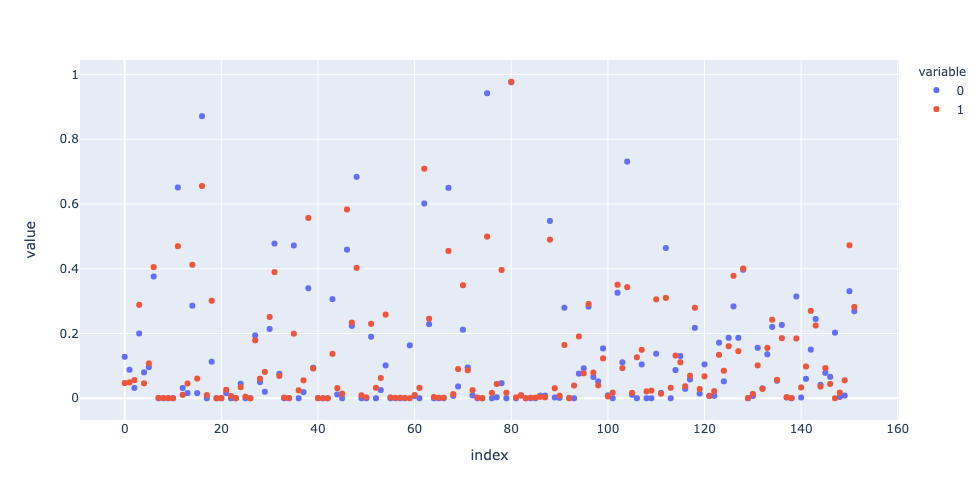

In [30]:
px.scatter(inferred_and_truth.values)